<a href="https://colab.research.google.com/github/shivanii27/Flower-Classification-CNN-TensorFlow-Keras/blob/main/Copy_of_Image_classification_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FLOWER CLASSIFICATION MODEL USING KERAS**

---



Isha Swami (enrollment no. - 02401192022) (internship roll no. - 23150)

Preshita Verma (enrollment no. - 04701192022) (internship roll no. - 23293)

Shivani (enrollment no. - 06001192022) (internship roll no. - 23375)

**SETUP**

Importing TensorFlow and other necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**DOWNLOAD AND EXPLORE THE DATASET**

This model uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

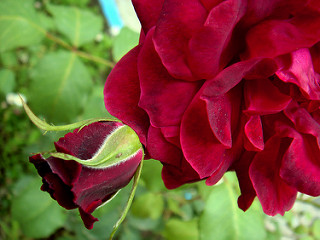

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

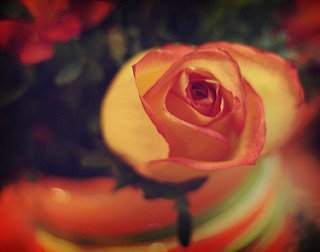

In [ ]:
PIL.Image.open(str(roses[1]))

And some tulips:

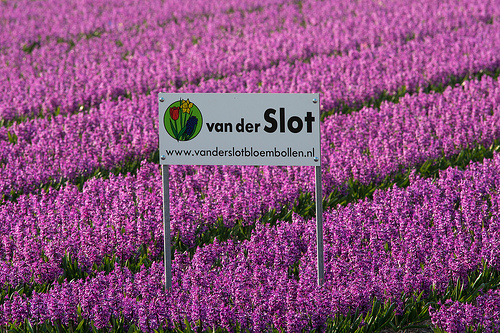

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

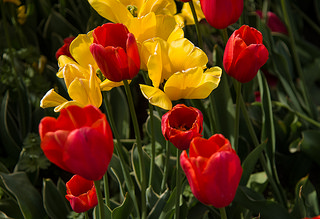

In [ ]:
PIL.Image.open(str(tulips[1]))

**LOAD DATA USING A KERAS UTILITY**

Following that, you can retrieve these images from your storage using the convenient tf.keras.utils.image_dataset_from_directory tool. With just a few lines of code, this method converts a directory containing images into a tf.data.Dataset. Alternatively, you have the option to create your own data loading code from the ground up by referring to the Load and preprocess images tutorial.

**CREATE A DATASET**

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**VISUALIZE THE DATA**

Here are the first nine images from the training dataset:

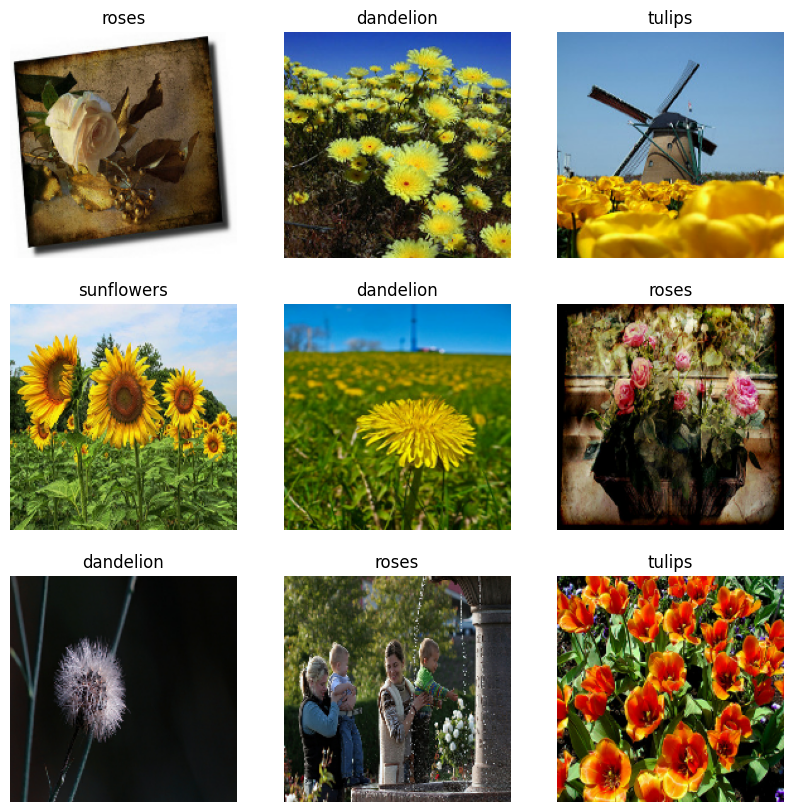

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We will pass these datasets to the Keras Model.fit method for training later.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch represents a tensor with a size of (32, 180, 180, 3). It contains 32 images, each measuring 180x180 pixels with three color channels (Red, Green, Blue). As for the label_batch, it forms a tensor with a shape of (32,), containing labels that correspond to the 32 images.

To transform these tensors into numpy.ndarray format, we can simply apply the .numpy() method on both the image_batch and label_batch tensors.

**CONFIGURE THE DATASET FOR PERFORMANCE**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**STANDARDIZE THE DATA**


The RGB channel values fall within a range of 0 to 255, which isn't optimal for a neural network. In general, we should aim to have smaller input values.

Here, we will standardize values to be in the **[0, 1]** range by using **tf.keras.layers.Rescaling**:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. We will apply it to the dataset by calling **Dataset.map**:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99930793


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

**A BASIC KERAS MODEL**

**Create the model**



The Keras Sequential model is composed of three sets of convolution blocks **(tf.keras.layers.Conv2D)** , each followed by a max pooling layer **(tf.keras.layers.MaxPooling2D)** . Additionally, there is a fully-connected layer **(tf.keras.layers.Dense)**  with 128 units at the top, which is activated using the ReLU activation function ('relu'). It's important to note that this model hasn't been fine-tuned for achieving the highest accuracy. The primary aim of this tutorial is to demonstrate a typical approach.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile the model**

For this model, we choose the **tf.keras.optimizers.Adam** optimizer and **tf.keras.losses.SparseCategoricalCrossentropy** loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**MODEL SUMMARY**

View all the layers of the network using the Keras **model.summary** method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**TRAIN THE MODEL**

Train the model for 10 epochs with the Keras **model.fit** method:

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 130s 1s/step - loss: 1.3808 - accuracy: 0.4070 - val_loss: 1.1081 - val_accuracy: 0.5559
Epoch 2/10
92/92 [==============================] - 121s 1s/step - loss: 1.0461 - accuracy: 0.5899 - val_loss: 0.9726 - val_accuracy: 0.6226
Epoch 3/10
92/92 [==============================] - 127s 1s/step - loss: 0.8457 - accuracy: 0.6737 - val_loss: 0.9049 - val_accuracy: 0.6458
Epoch 4/10
92/92 [==============================] - 129s 1s/step - loss: 0.6272 - accuracy: 0.7674 - val_loss: 0.9446 - val_accuracy: 0.6281
Epoch 5/10
92/92 [==============================] - 130s 1s/step - loss: 0.4097 - accuracy: 0.8556 - val_loss: 1.1125 - val_accuracy: 0.6308
Epoch 6/10
92/92 [==============================] - 121s 1s/step - loss: 0.2443 - accuracy: 0.9172 - val_loss: 1.2823 - val_accuracy: 0.6471
Epoch 7/10
92/92 [==============================] - 117s 1s/step - loss: 0.1321 - accuracy: 0.9632 - val_loss: 1.6624 - val_accuracy: 0.6008
Epoch 8/10
92

**VISUALIZE TRAINING RESULTS**

Create plots of the loss and accuracy on the training and validation sets:

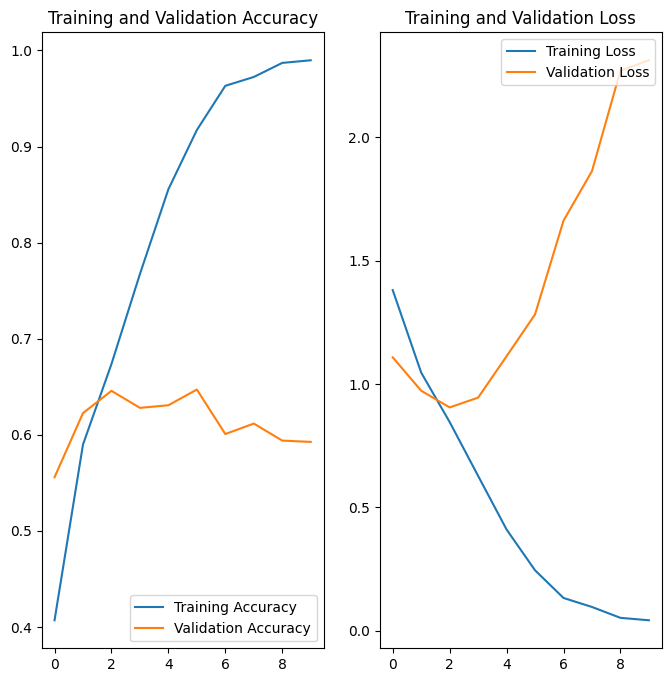

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

**OVERFITTING**

In the plots above, we can observe that the training accuracy steadily rises over time, while the validation accuracy plateaus at approximately 60% during the training process. Additionally, there is a clear disparity in accuracy between the training and validation sets, which indicates the presence of overfitting.

When the training dataset contains only a limited number of examples, there are instances when the model ends up learning from irrelevant details or noise present in these examples. This can be detrimental to the model's ability to perform well on new, unseen examples. This issue is commonly referred to as overfitting, indicating that the model struggles to make accurate predictions when applied to a different dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.

**DATA AUGMENTATION**

Overfitting typically happens when there is a limited set of training instances. Data augmentation involves the strategy of creating extra training data from your current samples by applying random changes that produce realistic images. This approach aids in exposing the model to various facets of the data, resulting in improved generalization.

We aaply data augmentation using the following Keras preprocessing layers: **tf.keras.layers.RandomFlip**, **tf.keras.layers.RandomRotation**, and **tf.keras.layers.RandomZoom**.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

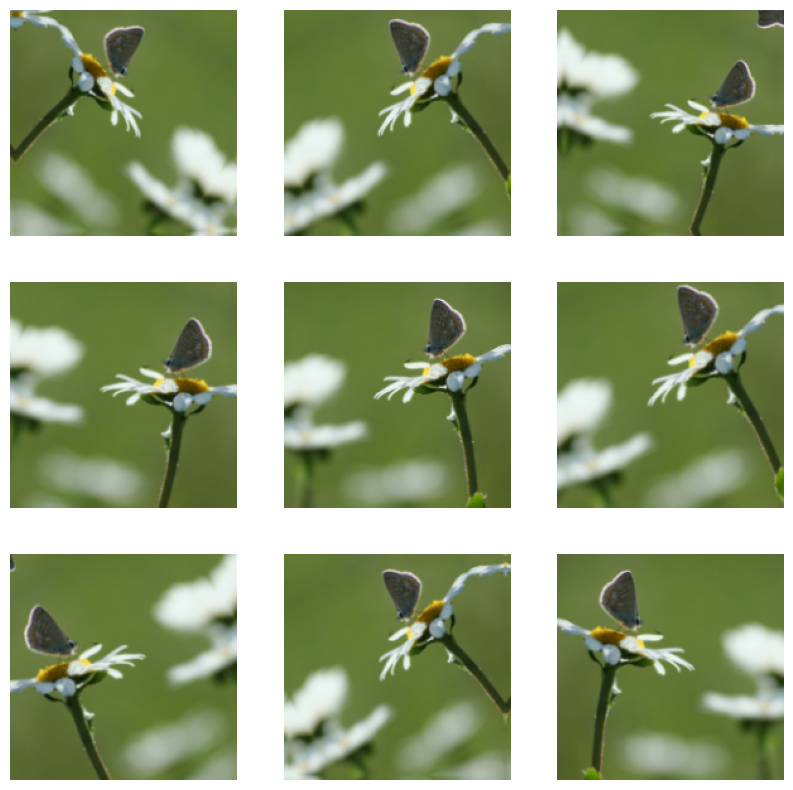

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We will add data augmentation to our model before training in the next step.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 138s 1s/step - loss: 1.3644 - accuracy: 0.4213 - val_loss: 1.2720 - val_accuracy: 0.5014
Epoch 2/15
92/92 [==============================] - 135s 1s/step - loss: 1.0602 - accuracy: 0.5634 - val_loss: 0.9675 - val_accuracy: 0.6253
Epoch 3/15
92/92 [==============================] - 137s 1s/step - loss: 0.9431 - accuracy: 0.6383 - val_loss: 0.9024 - val_accuracy: 0.6485
Epoch 4/15
92/92 [==============================] - 136s 1s/step - loss: 0.8940 - accuracy: 0.6465 - val_loss: 0.9005 - val_accuracy: 0.6526
Epoch 5/15
92/92 [==============================] - 141s 2s/step - loss: 0.8336 - accuracy: 0.6815 - val_loss: 0.8354 - val_accuracy: 0.6894
Epoch 6/15
92/92 [==============================] - 136s 1s/step - loss: 0.7877 - accuracy: 0.6924 - val_loss: 0.8072 - val_accuracy: 0.6757
Epoch 7/15
92/92 [==============================] - 139s 2s/step - loss: 0.7436 - accuracy: 0.7238 - val_loss: 0.7953 - val_accuracy: 0.6826
Epoch 8/15
92

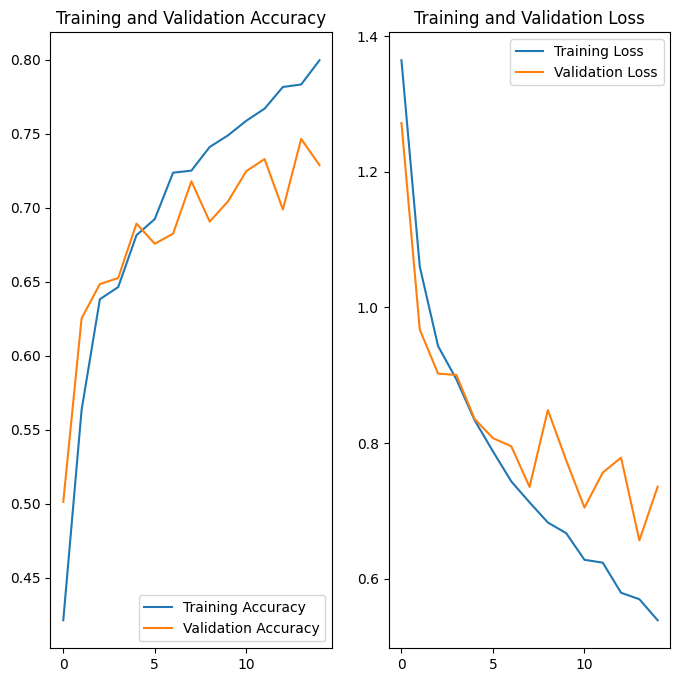

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 196ms/step
This image most likely belongs to sunflowers with a 98.89 percent confidence.


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)